Objetivo del ejercicio: 
Encontrar un modelo que logre predecir de forma precisa el precio de renta de un inmueble en Nueva York, usando la información disponible, se deben evaluar diferentes metricas de error y tratar de minimizarlo en diferentes iteraciones tratando de buscar el mejor modelo para predecir el precio por día de las casas en Nueva york de forma generalizable.
* Nota:
Se debe tener en cuenta que una subestimación del precio por encima del 20% puede generar costos adicionales muy altos dado posibles errores en las proyecciones y no es aceptable en mayor medida un comportamiento de subestimación alta pues dado ello se asumen perdidas. 

- 1) id: Un identificador único para cada anuncio de Airbnb en el conjunto de datos.
- 2) name: El nombre o título del anuncio de Airbnb, a menudo proporcionado por el anfitrión para describir la propiedad.
- 3) host_id: Un identificador único para cada anfitrión en Airbnb, que permite conexiones entre los anfitriones y sus anuncios.
- 4) host_name: El nombre del anfitrión que gestiona el anuncio de Airbnb.
- 5) neighbourhood_group: La región geográfica más amplia o grupo dentro del cual se encuentra el barrio.
- 6) neighbourhood: El barrio específico o área donde está situada la propiedad de Airbnb.
- 7) latitude: La coordenada de latitud geográfica de la ubicación del anuncio de Airbnb.
- 8) longitude: La coordenada de longitud geográfica de la ubicación del anuncio de Airbnb.
- 9) room_type: El tipo de habitación o alojamiento ofrecido por el anuncio de Airbnb (por ejemplo, casa/apartamento entero, habitación privada, habitación compartida).
- 10) price: El precio de alquiler por noche para el anuncio de Airbnb.
- 11) minimum_nights: El número mínimo de noches requeridas para reservar el anuncio de Airbnb.
- 12) number_of_reviews: El número total de reseñas dejadas por huéspedes que se han alojado en el anuncio de Airbnb.
- 13) last_review: La fecha de la reseña más reciente dejada por un huésped para el anuncio de Airbnb.
- 14) reviews_per_month: El número promedio de reseñas recibidas por mes para el anuncio de Airbnb.
- 15) calculated_host_listings_count: El conteo de anuncios gestionados por el anfitrión, incluyendo el actual, en la plataforma de Airbnb.
- 16) availability_365: El número de días en el año que el anuncio de Airbnb está disponible para reservar.


Modelo supervisado, el target es conocido.

## Librerias y configuraciones previas

In [144]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import folium
from folium.plugins import HeatMap
import optuna
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from lightgbm import LGBMRegressor
from pandas.plotting import scatter_matrix
from sklearn.metrics import make_scorer
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from optuna.visualization import plot_param_importances
from utils.funciones import multiple_plot
import joblib
pd.reset_option('display.max_columns')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error



## 2)  Funciones

In [219]:
def mape(y_true, y_pred, epsilon=1e-8):
    """Calculate mean absolute percentage error, adjusted to avoid division by zero."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    differences = y_true - y_pred
    absolutes = np.abs(differences)
    division = absolutes / (np.abs(y_true) + epsilon)  # Use abs(y_true) to ensure non-negative denominator
    mean_value = np.mean(division) * 100
    return mean_value

def evaluar_predicciones(y_real, y_pred):
    # Convertir los inputs en arrays de numpy si aún no lo son
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)
    
    # Calcular el error porcentual
    errores = (y_pred - y_real) / y_real * 100
    
    # Definir las condiciones para la clasificación
    condiciones = [
        errores < -20,
        errores > 20,
        (errores >= -20) & (errores <= 20)
    ]
    
    # Definir las categorías correspondientes a cada condición
    categorias = ['Subestima', 'Sobrestima', 'Dentro del rango']
    
    # Usar numpy.select para asignar categorías basadas en las condiciones
    clasificacion = np.select(condiciones, categorias, default='Revisar')  # 'default' es opcional
    
    # Crear DataFrame de resultados
    resultados = pd.DataFrame({
        'Real': y_real,
        'Predicción': y_pred,
        'Error %': errores,
        'Clasificación': clasificacion
    })
    
    return resultados


def evaluate_regression_model(model, X, y):
    """
    Evaluar el modelo de regresión en un conjunto de datos.
    Parameters:
    - model: modelo entrenado de regresión.
    - X: características
    - y: valores reales (target).
    Returns:
    - Un diccionario con R2, RMSE, MAPE, MAE.
    """
    # Predicciones del modelo
    y_pred = model.predict(X)
    
    # Calcular el coeficiente de determinación R^2
    r2 = r2_score(y, y_pred)
    
    # Calcular el Root Mean Square Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Calcular el Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, y_pred)
    
    # Calcular el Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    
    # Compilar todas las métricas en un diccionario
    metrics = {
        'R^2': r2,
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
    
    return metrics
def evaluate_regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape, mae

##  3) Carga del dataset

In [146]:
df=pd.read_csv(r"AB_NYC_2019.csv") ## Cargo dataset de airbnb newyork 

## 4) Visualización de datos

In [147]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Variables numericas

In [148]:
numCols=df.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
df[numCols].head(2)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,40.6475,-73.9724,149,1,9,0.2100,6,365
1,2595,2845,40.7536,-73.9838,225,1,45,0.3800,2,355


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



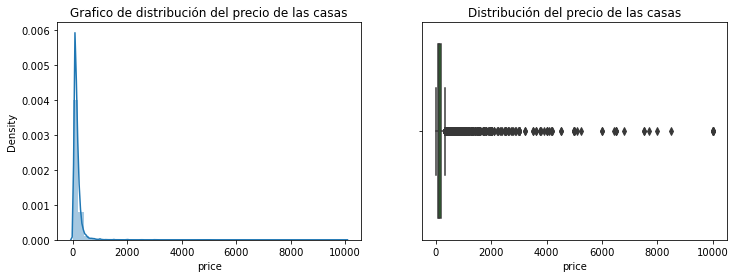

In [149]:
#Histográma y caja de bigotes del precio de los vehículos
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Grafico de distribución del precio de las casas')
sns.distplot(df.price)
plt.subplot(1,2,2)
plt.title('Distribución del precio de las casas')
sns.boxplot(x=df.price, palette='nipy_spectral')
plt.show()

* Se identifican las distribuciones del precio de las casas en new york y se capturan varios outliers que pueden hacer compleja la predicción, además de ello se identifican que hay precios cero

In [150]:
## check duplicados
print("Valido si hay presencia de duplicados: ",df[df.duplicated()])

print("tamaño del dataset",df.shape,"host ids unicos", df['host_id'].nunique(),"ids unicos del dataset",df['id'].nunique())
df.drop(['host_id','id'],axis=1,inplace=True)
df=df[~(df['price']==0)]#.shape ### hay 11 registros que no se van a tener en cuenta dado que no hay precios ceros y se consideran un dato errado para dicho ejercicio.
df['price'].describe()

Valido si hay presencia de duplicados:  Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []
tamaño del dataset (48895, 16) host ids unicos 37457 ids unicos del dataset 48895


count   48884.0000
mean      152.7551
std       240.1703
min        10.0000
25%        69.0000
50%       106.0000
75%       175.0000
max     10000.0000
Name: price, dtype: float64

* No hay duplicados presentes en el dataset en todas su columnas

In [151]:
# Estadísticas descriptivas
display(df.describe())

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.0000,48884.0000,48884.0000,48884.0000,48884.0000,38833.0000,48884.0000,48884.0000
mean,40.7290,-73.9522,152.7551,7.0299,23.2720,1.3731,7.1446,112.7795
std,0.0545,0.0462,240.1703,20.5122,44.5513,1.6804,32.9562,131.6273
min,40.4998,-74.2444,10.0000,1.0000,0.0000,0.0100,1.0000,0.0000
25%,40.6901,-73.9831,69.0000,1.0000,1.0000,0.1900,1.0000,0.0000
50%,40.7231,-73.9557,106.0000,3.0000,5.0000,0.7200,1.0000,45.0000
75%,40.7631,-73.9363,175.0000,5.0000,24.0000,2.0200,2.0000,227.0000
max,40.9131,-73.7130,10000.0000,1250.0000,629.0000,58.5000,327.0000,365.0000


In [152]:
## Se identifica que tipos de variables hay en el dataset
types = pd.DataFrame(df.dtypes)

types.groupby(0).size()

0
int64      5
float64    3
object     6
dtype: int64

In [153]:
types = pd.DataFrame(df.dtypes)
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(df[line].unique()))+" valores distintos")

La variable name contiene: 47895 valores distintos
La variable host_name contiene: 11451 valores distintos
La variable neighbourhood_group contiene: 5 valores distintos
La variable neighbourhood contiene: 221 valores distintos
La variable room_type contiene: 3 valores distintos
La variable last_review contiene: 1765 valores distintos


In [154]:
barrios_turisticos = [
    "Midtown Manhattan", "Upper West Side", "Upper East Side", "Financial District",
    "Battery Park City", "Greenwich Village", "SoHo", "Chelsea", "Chinatown",
    "Little Italy", "Harlem", "Williamsburg", "DUMBO"
] ### https://capturetheatlas.com/es/barrios-de-nueva-york/ busqueda en google para no perder variables y tener más info no con tanta cardinalidad

In [155]:
barrios_turisticos_lower = [barrio.lower() for barrio in barrios_turisticos]
df['neighbourhood_turista']=np.where(df['neighbourhood'].str.lower().isin(barrios_turisticos_lower),1,0)

* Host name, presenta alta cardinalidad, y al aplicarle one-hot encoding sufririamos del problema de la maldición de la dimensionalidad
* neighbourhood tambien presenta 225 barrios que se podrian agrupar como barrios secundarios o primarios

## Visualización de datos

In [156]:
# Distribuciones de la ,uestra por cada barrio
neighborhood_counts = df['neighbourhood_group'].value_counts().reset_index()
neighborhood_counts.columns = ['Neighborhood', 'Count']
fig = px.bar(neighborhood_counts, x='Neighborhood', y='Count', 
color='Neighborhood',title='Airbnb precios por grupo de barrios')
fig.update_layout(title={'text': 'Airbnb precios por grupo de barrios','x': 0.5}
)
fig.show()

In [157]:
df['neighbourhood_group'].value_counts(1)*100

Manhattan       44.3090
Brooklyn        41.1075
Queens          11.5907
Bronx            2.2298
Staten Island    0.7630
Name: neighbourhood_group, dtype: float64

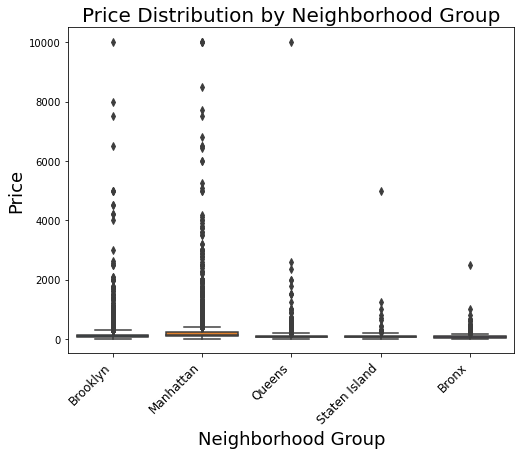

In [158]:
plt.figure(figsize=(8, 6)) 
boxplot = sns.boxplot(data=df, x='neighbourhood_group', y='price')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Adjust x labels
plt.xlabel('Neighborhood Group', fontsize=18)
plt.ylabel('Price', fontsize=18) 
plt.title('Price Distribution by Neighborhood Group', fontsize=20)
plt.show()

* Se observa gran dispersión de datos en cada uno del grupo de barrios, en menos medida en Bronx

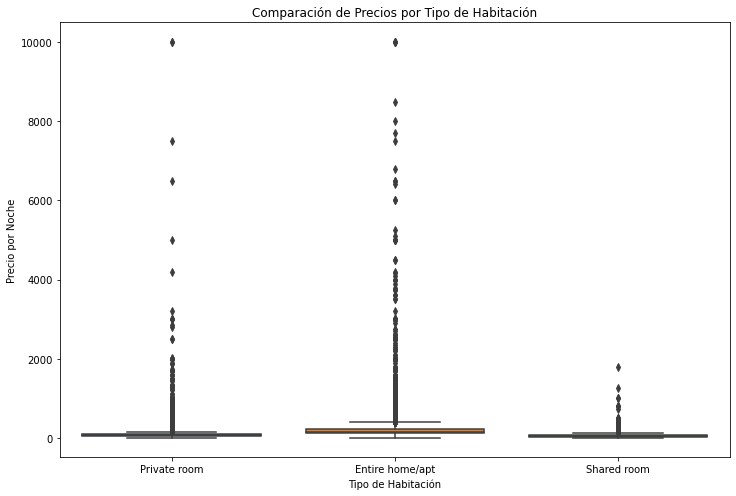

In [159]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Comparación de Precios por Tipo de Habitación')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Precio por Noche')
plt.show()

In [160]:
mean_lat = df['latitude'].mean()
mean_lon = df['longitude'].mean()

In [161]:
map = folium.Map(location=[mean_lat, mean_lon], zoom_start=11) 
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in df.iterrows()]
heat_layer = HeatMap(heat_data, 
                     min_opacity=0.5,
                     max_val=float(df['price'].max()),
                     radius=10, blur=20, 
                     max_zoom=1)
# Add the heat layer to the map
map.add_child(heat_layer)
# Save the map to an HTML file
map.save('heatmap.html')
map

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.



* Se crea un mapa con folium para observar donde se centran los precios más altos por localización el punto de caliente se centra muy cerca del rio judson

## Tratamiento de datos

In [162]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(df[line].unique()))+" distinct values")

La variable name contiene: 47895 distinct values
La variable host_name contiene: 11451 distinct values
La variable neighbourhood_group contiene: 5 distinct values
La variable neighbourhood contiene: 221 distinct values
La variable room_type contiene: 3 distinct values
La variable last_review contiene: 1765 distinct values


In [163]:
types = pd.DataFrame(df.dtypes)
print("Tipos de variables", types.groupby(0).size())

consolidado = df.replace({False: 0, True: 1})

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de reemplazo",types.groupby(0).size())

Tipos de variables 0
int32      1
int64      5
float64    3
object     6
dtype: int64
Tipos de variables luego de reemplazo 0
int32      1
int64      5
float64    3
object     6
dtype: int64


In [164]:
num_cols=df.select_dtypes(exclude='object').columns

In [165]:
df[num_cols].head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_turista
0,40.6475,-73.9724,149,1,9,0.2100,6,365,0
1,40.7536,-73.9838,225,1,45,0.3800,2,355,0
2,40.8090,-73.9419,150,3,0,NaN,1,365,1
3,40.6851,-73.9598,89,1,270,4.6400,1,194,0
4,40.7985,-73.9440,80,10,9,0.1000,1,0,0


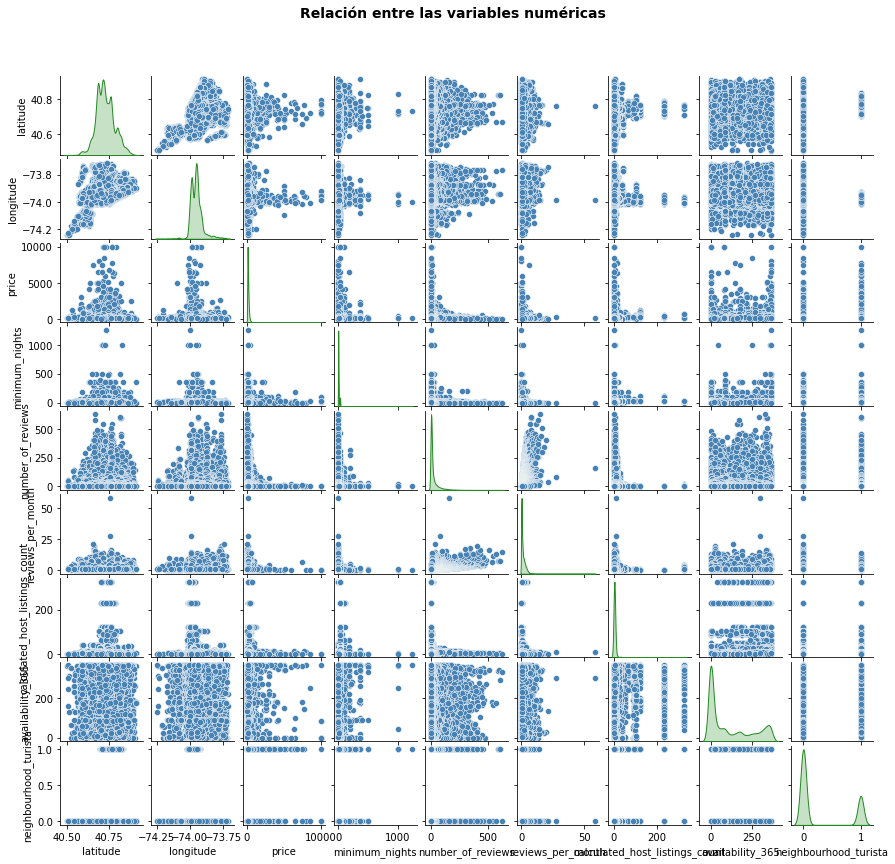

In [166]:
#Visualización de variables numéricas con respecto a las varaibles numericas
multiple_plot(1, df , num_cols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

* Si se observa longitud vs latitud no se ven datos atipicos o mal geolocalizados, pues no hay puntos que se alejan mucho unos de los otros, más aún si el ejercicio es unicamente para New York
* No se hallan relaciones a vista fuertes, procedemos a revisar correlaciones.

<AxesSubplot:>

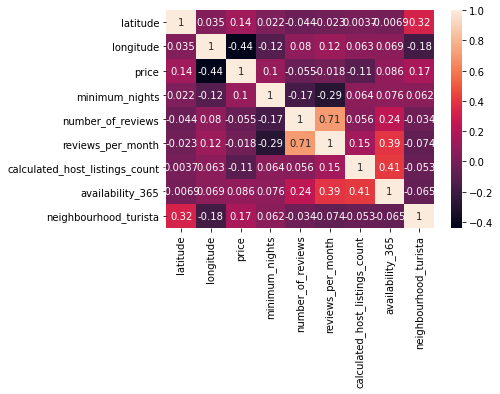

In [167]:
sns.heatmap(df[num_cols].corr(method='spearman'),annot=True)

* 0.71 es la correlación no lineal más alta entre las reseñas por mes.

* Elimino del entrenamiento los outliers usando el rango intercuantilico

In [168]:

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



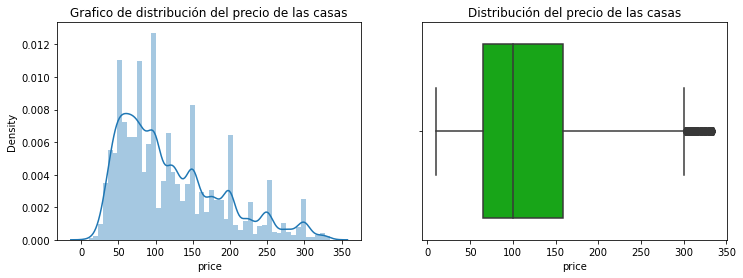

count   45912.0000
mean      119.9991
std        68.1330
min        10.0000
25%        65.0000
50%       100.0000
75%       159.0000
max       334.0000
Name: price, dtype: float64


In [169]:
#Histográma y caja de bigotes del precio de los vehículos
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Grafico de distribución del precio de las casas')
sns.distplot(df.price)
plt.subplot(1,2,2)
plt.title('Distribución del precio de las casas')
sns.boxplot(x=df.price, palette='nipy_spectral')
plt.show()
print(df['price'].describe())

In [170]:
num_cols=num_cols.to_list()

In [171]:
num_cols

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_turista']

In [172]:
num_cols.remove('neighbourhood_turista')

In [173]:
df['neighbourhood_group2']=df['neighbourhood_group'] ## duplico la variable para poder realizar ejercicios posteriores
X = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type']).drop(['neighbourhood'],axis=1)
X.drop(['name','host_name','last_review'],axis=1,inplace=True)

In [174]:
y=df['price']

In [175]:
X['reviews_per_month']=X['reviews_per_month'].fillna(0)

In [176]:
## Se realiza la división del dataset de modo que se guarde un porcentaje de la data para validación
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)
print("Training set size: ", X_train.shape)
print("Validation set size: ", X_val.shape)
print("Test set size: ", X_test.shape)

Training set size:  (27546, 18)
Validation set size:  (9183, 18)
Test set size:  (9183, 18)


In [177]:
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

In [178]:
a=['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room','neighbourhood_turista']

## modelo de linea base sin tuneo de hiperparametros

* Llamado  ensamble debil

In [179]:
model = LGBMRegressor(random_state=42)
model.fit(X_train[a], y_train)
y_pred = model.predict(X_test[a])
baseline_mape = mape(y_test, y_pred)
print(f"Baseline MAPE: {baseline_mape*100:.2f}%")


Baseline MAPE: 3103.02%


In [180]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = model.predict(X = X_test[a])

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 43.67428354182945
El error (r2) de test es: 0.578753435166282


## Optuna
* a. API de "definición por ejecución" que permite construir dinámicamente el espacio de búsqueda de parámetros.
* b. Implementación eficiente de estrategias de búsqueda y poda.
* c. Configuración fácil y arquitectura versátil para diferentes casos de uso (distribuido, interactivo, etc.)
Optuna se presenta como una implementación que satisface estos nuevos criterios, siendo el primer software de optimización que adopta el principio de "definición por ejecución".
El documento discute las técnicas de diseño utilizadas para cumplir con los criterios propuestos en el desarrollo de Optuna.
Los resultados experimentales y las aplicaciones en el mundo real se utilizan para demostrar las capacidades del nuevo diseño de Optuna.
Optuna es un software de código abierto disponible bajo la licencia MIT.

Referencia: 
* Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019.
Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD.

Lightgbm: 
* LightGBM es un marco de trabajo de impulso de gradiente que utiliza algoritmos de aprendizaje basados en árboles. Está diseñado para ser distribuido y eficiente, con las siguientes ventajas:

Mayor velocidad de entrenamiento y mayor eficiencia.
Menor uso de memoria.
Mejor precisión.
Soporte para aprendizaje paralelo, distribuido y en GPU.
Capaz de manejar datos a gran escala.

Referencia: 
Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., ... & Liu, T. Y. (2017). Lightgbm: A highly efficient gradient boosting decision tree. Advances in neural information processing systems, 30.

Random forest

* Las predicciones de árboles individuales son inestables debido a pequeños cambios en 𝐷
* Sin embargo, la combinación de muchos árboles (es decir, un bosque) es más estable.
* Un bosque aleatorio es un conjunto de múltiples árboles de decisión aleatorizados.
* Es popular debido a su precisión y capacidad para manejar tamaños pequeños de muestras y espacios de características de alta dimensión.
Los árboles en el conjunto se construyen a partir de muestras bootstrap de 𝐷
D (es decir, bagging), pero también, se introduce aleatoriedad para obtener árboles decorrelacionados.

Referencia Santiago Gallon notas de clase May 23, 2019

Segunda definición:

Un Random Forest es un metaestimador que ajusta una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 

**Parametros:**
- **n_estimators:** (default=100) número de árboles del bosque
- **max_depth:** (default=None) La profundidad máxima del árbol. Si es `None`, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos ejemplos del parametro min_samples_split.
- **max_features:** (default=1.0) El número de características a considerar al buscar la mejor división
    - auto, None o 1.0: max_features=n_features.
    - sqrt: max_features=sqrt(n_features).
    - log2: max_features=log2(n_features).

- **bootstrap:**(default=True) Si se utilizan muestras al construir árboles. Si es False, se usa todo el conjunto de datos para construir cada árbol.

- **oob_score:** (default=False) si usa ejemplos out-of-bag para estimar un score de generalización. Solo disponible si bootstrap = True.

Referencia Jorge Bedoya notebook de clase 2024 12_ArbolesDecisionRandomForestRegresion.ipynb


## Algoritmos a usar


In [181]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['GradientBoosting', 'SVM', 'RandomForest', 'LightGBM'])

    if model_type == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 12)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                          subsample=subsample, random_state=42)
    
    elif model_type == 'SVM':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        epsilon = trial.suggest_float('epsilon', 0.01, 0.5)
        model = SVR(C=C, gamma=gamma, kernel=kernel, epsilon=epsilon)
    
    elif model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 40, 100)
        max_depth = trial.suggest_int('max_depth', 3, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)

    elif model_type == 'LightGBM':
        num_leaves = trial.suggest_int('num_leaves', 2, 100)
        max_depth = trial.suggest_int('max_depth', -1, 50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 400)
        sub_feature = trial.suggest_float('sub_feature', 0.5, 1.0)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 20, 100)
        max_bin = trial.suggest_int('max_bin', 255, 500)
        model = LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                              sub_feature=sub_feature, min_data_in_leaf=min_data_in_leaf, max_bin=max_bin)

    model.fit(X_train[a], y_train)
    y_pred = model.predict(X_test[a])
    return mape(y_test, y_pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # Adjust number of trials as needed
print("Best trial:")
print(study.best_trial)

[I 2024-05-07 21:50:01,774] A new study created in memory with name: no-name-d8ad0ffb-54cf-4b9c-86bd-8611ea86488f
[I 2024-05-07 21:50:02,801] Trial 0 finished with value: 33.16510743919704 and parameters: {'model_type': 'RandomForest', 'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 33.16510743919704.
[I 2024-05-07 21:51:05,231] Trial 1 finished with value: 51.03892795803422 and parameters: {'model_type': 'SVM', 'C': 0.012955044159357833, 'gamma': 0.008235415502183813, 'kernel': 'rbf', 'epsilon': 0.12908004991468142}. Best is trial 0 with value: 33.16510743919704.
[I 2024-05-07 21:51:06,234] Trial 2 finished with value: 34.198790812676336 and parameters: {'model_type': 'RandomForest', 'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 33.16510743919704.
[I 2024-05-07 21:51:07,537] Trial 3 finished with value: 31.275

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6910010178634434. Current value: feature_fraction=0.6910010178634434
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2024-05-07 21:51:16,415] Trial 6 finished with value: 31.448263805999833 and parameters: {'model_type': 'LightGBM', 'num_leaves': 71, 'max_depth': 23, 'learning_rate': 0.014203626308859865, 'n_estimators': 305, 'sub_feature': 0.6910010178634434, 'min_data_in_leaf': 45, 'max_bin': 490}. Best is trial 3 with value: 31.275806916474753.
[I 2024-05-07 21:51:18,519] Trial 7 finished with value: 30.986795664141464 and parameters: {'model_type': 'RandomForest', 'n_estimators': 90, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 7 with value: 30.986795664141464.
[I 2024-05-07 21:51:18,705] Trial 8 finished with value: 34.66258161547003 and parameters: {'model_type': 'LightGBM', 'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.011885773692433111, 'n_estimators': 269, 'sub_feature': 0.8757993818679853, 'min_data_in_leaf': 95, 'max_bin': 386}. Best is trial 7 with value: 30.986795664141464.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8757993818679853. Current value: feature_fraction=0.8757993818679853
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9431807828218196. Current value: feature_fraction=0.9431807828218196
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2024-05-07 21:51:19,288] Trial 9 finished with value: 30.71302600475505 and parameters: {'model_type': 'LightGBM', 'num_leaves': 92, 'max_depth': 41, 'learning_rate': 0.03337048305543249, 'n_estimators': 223, 'sub_feature': 0.9431807828218196, 'min_data_in_leaf': 39, 'max_bin': 337}. Best is trial 9 with value: 30.71302600475505.
[I 2024-05-07 21:51:19,501] Trial 10 finished with value: 33.33831985265463 and parameters: {'model_type': 'LightGBM', 'num_leaves': 2, 'max_depth': 50, 'learning_rate': 0.09256420750745907, 'n_estimators': 382, 'sub_feature': 0.9667841398050351, 'min_data_in_leaf': 24, 'max_bin': 265}. Best is trial 9 with value: 30.71302600475505.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9667841398050351. Current value: feature_fraction=0.9667841398050351
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2024-05-07 21:52:00,302] Trial 11 finished with value: 33.14255308225507 and parameters: {'model_type': 'SVM', 'C': 950.7192151340951, 'gamma': 0.00020235634155545278, 'kernel': 'sigmoid', 'epsilon': 0.4741589599734308}. Best is trial 9 with value: 30.71302600475505.
[I 2024-05-07 21:52:08,196] Trial 12 finished with value: 30.46924973711486 and parameters: {'model_type': 'GradientBoosting', 'n_estimators': 137, 'max_depth': 12, 'learning_rate': 0.04068271306320192, 'min_samples_split': 4, 'min_samples_leaf': 10, 'subsample': 0.5185366974891557}. Best is trial 12 with value: 30.46924973711486.
[I 2024-05-07 21:52:16,302] Trial 13 finished with value: 30.576859961630586 and parameters: {'model_type': 'GradientBoosting', 'n_estimators': 143, 'max_depth': 12, 'learning_rate': 0.04552505023668891, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.5178177589697748}. Best is trial 12 with value: 30.46924973711486.
[I 2024-05-07 21:52:22,973] Trial 14 finished with value: 30.4

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5217769185394296. Current value: feature_fraction=0.5217769185394296
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
Best trial:
FrozenTrial(number=32, state=TrialState.COMPLETE, values=[30.378875633743196], datetime_start=datetime.datetime(2024, 5, 7, 21, 55, 39, 278536), datetime_complete=datetime.datetime(2024, 5, 7, 21, 55, 52, 332697), params={'model_type': 'GradientBoosting', 'n_estimators': 173, 'max_depth': 12, 'learning_rate': 0.03727098935690343, 'min_samples_split': 7, 'min_samples_leaf': 10, 'subsample': 0.562630329115334}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('GradientBoosting', 'SVM', 'RandomForest', 'LightGBM')), 'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(hi

In [182]:
iter_2 = study.trials_dataframe()#.index[21:24]

In [183]:
iter_2[18:19]

,number,value,datetime_start,datetime_complete,duration,params_C,params_epsilon,params_gamma,params_kernel,params_learning_rate,...,params_max_features,params_min_data_in_leaf,params_min_samples_leaf,params_min_samples_split,params_model_type,params_n_estimators,params_num_leaves,params_sub_feature,params_subsample,state
18,18,31.9852,2024-05-07 21:52:43.237778,2024-05-07 21:52:52.120948,0 days 00:00:08.883170,NaN,NaN,NaN,NaN,0.1871,...,NaN,NaN,10.0000,3.0000,GradientBoosting,159.0000,NaN,NaN,0.6542,COMPLETE


In [184]:
best_trial = study.best_trial
print("Best trial ID: {}".format(best_trial.number))
print("Best trial value (lowest MAPE): {:.2f}".format(best_trial.value))
print("Best parameters:")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))
    
if 'model_type' in best_trial.params:
    model_type = best_trial.params['model_type']
    if model_type == 'GradientBoosting':
        from sklearn.ensemble import GradientBoostingRegressor
        model = GradientBoostingRegressor(**{k: v for k, v in best_trial.params.items() if k != 'model_type'})
    elif model_type == 'SVM':
        from sklearn.svm import SVR
        model = SVR(**{k: v for k, v in best_trial.params.items() if k != 'model_type'})
    elif model_type == 'RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**{k: v for k, v in best_trial.params.items() if k != 'model_type'})
    elif model_type == 'LightGBM':
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**{k: v for k, v in best_trial.params.items() if k != 'model_type'})
    
    model.fit(X_train[a], y_train) 
    y_pred = model.predict(X_test[a])#.astype(int)
    test_mape = mape(y_test, y_pred)  
    print("MAPE on test data: {:.2f}".format(test_mape))

Best trial ID: 32
Best trial value (lowest MAPE): 30.38
Best parameters:
  model_type: GradientBoosting
  n_estimators: 173
  max_depth: 12
  learning_rate: 0.03727098935690343
  min_samples_split: 7
  min_samples_leaf: 10
  subsample: 0.562630329115334
MAPE on test data: 30.31


* Las funciones del núcleo más comunes son lineal y
la función de base radial o RBF (conjunto de núcleos
locales en forma de Gauss para encontrar una
separación no lineal de las clases).


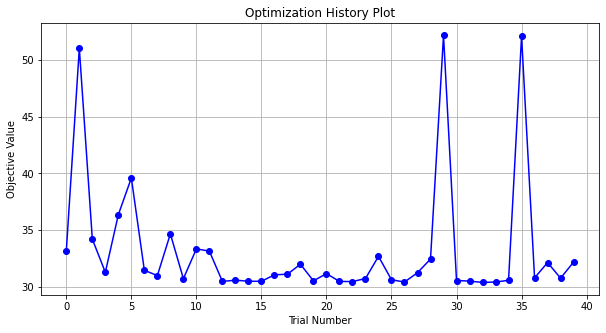

In [185]:
plt.figure(figsize=(10, 5))
plt.plot(iter_2['number'], iter_2['value'], marker='o', linestyle='-', color='b')
plt.title('Optimization History Plot')
plt.xlabel('Trial Number')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()
# Plot parameter importance
plot_param_importances(study)
plt.show()

In [186]:
iter_2.groupby(['params_model_type']).agg({'value':['mean','count']})
### con esto hiperparametros establecidos y en nuestra grila oficial el mejor resultado lo obtiene el SVM

value      
                     mean count
params_model_type              
GradientBoosting  31.2321    23
LightGBM          32.4677     5
RandomForest      32.5029     7
SVM               44.2298     5

In [187]:
model

GradientBoostingRegressor(learning_rate=0.03727098935690343, max_depth=12,
                          min_samples_leaf=10, min_samples_split=7,
                          n_estimators=173, subsample=0.562630329115334)

In [188]:
joblib.dump(model, 'objetos/best_model_iter_2.joblib')

['objetos/best_model_iter_2.joblib']

In [189]:
# evaluación de resultados 

In [190]:
evaluate_regression_model(model, X_train[a], y_train)

{'R^2': 0.7758124472627804,
 'RMSE': 32.30297853336143,
 'MAPE': 21.724442943879517,
 'MAE': 22.856791513502195}

In [191]:
evaluate_regression_model(model, X_test[a], y_test)

{'R^2': 0.5824931015716212,
 'RMSE': 43.47998954411561,
 'MAPE': 30.3093204527193,
 'MAE': 31.186821984585283}

In [192]:
evaluate_regression_model(model, X_val[a], y_val)

{'R^2': 0.5884408954764766,
 'RMSE': 44.06131054494568,
 'MAPE': 30.210831462413413,
 'MAE': 31.61910278569793}

In [193]:
y_pred_val=model.predict(X_val[a])
y_pred_train=model.predict(X_train[a])
out_train=evaluar_predicciones(y_train,y_pred_train)
out_val=evaluar_predicciones(y_val,y_pred_val)

* Porcentaje de distribución por cada rango
- Se cumple con el objetivo inicial, pero se va a tratar de iterar dicho mejor modelo con una grilla más amplia y se procede a realizar la explicabiliadad correspondeinte, se decide dado que hay un sobre ajuste, que se debe controlar y se manifiesta desde la disminución del R2, RMSE y el Mape, se va a tratar de regularizar más con la norma l1 y/o l2.

In [194]:
out_train['Clasificación'].value_counts(1)*100

Dentro del rango   59.5005
Sobrestima         27.9968
Subestima          12.5027
Name: Clasificación, dtype: float64

In [195]:
out_val['Clasificación'].value_counts(1)*100

Dentro del rango   45.7476
Sobrestima         35.3588
Subestima          18.8936
Name: Clasificación, dtype: float64

In [196]:
out_val.head()

,Real,Predicción,Error %,Clasificación
0,115,167.2704,45.4525,Sobrestima
1,150,154.2566,2.8378,Dentro del rango
2,200,145.1535,-27.4232,Subestima
3,155,128.6129,-17.0239,Dentro del rango
4,75,78.9419,5.2559,Dentro del rango


In [197]:
classifications = out_train['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_train[out_train['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_t = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_t.reset_index(inplace=True)
df_results_t.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_t)

     Classification    RMSE    MAPE     MAE
0  Dentro del rango 15.3511  9.0709 11.4414
1         Subestima 66.7031 29.5994 59.4063
2        Sobrestima 35.2045 45.0998 30.7953


In [198]:
classifications = out_val['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_val[out_val['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    # Guardar los resultados en el diccionario
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_val = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_val.reset_index(inplace=True)
df_results_val.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_val)

     Classification    RMSE    MAPE     MAE
0        Sobrestima 44.3776 54.8938 38.3902
1  Dentro del rango 15.3592  9.4865 11.7245
2         Subestima 77.5797 34.1978 67.1186


In [199]:
df_results_t['set']='train'
df_results_val['set']='test'

In [200]:
iter1_=pd.concat([df_results_t,df_results_val]).sort_values('Classification')
iter1_

,Classification,RMSE,MAPE,MAE,set
0,Dentro del rango,15.3511,9.0709,11.4414,train
1,Dentro del rango,15.3592,9.4865,11.7245,test
2,Sobrestima,35.2045,45.0998,30.7953,train
0,Sobrestima,44.3776,54.8938,38.3902,test
1,Subestima,66.7031,29.5994,59.4063,train
2,Subestima,77.5797,34.1978,67.1186,test


In [201]:
iter_1_count=out_val['Clasificación'].value_counts(1)*100

** En la subestimación el mape es menor que en la sobreestimación, para el caso el ejercicio nos pide estar en rango lo más posible y evitar al maximo la subestimación. 

## creación de segunda iteración con el mejor modelo anterior

In [204]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 50)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    sub_feature = trial.suggest_float('sub_feature', 0.5, 1.0)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 100, 200)
    max_bin = trial.suggest_int('max_bin', 255, 500)
    reg_alpha = trial.suggest_float('reg_alpha', 10, 20) ## añado regularizadores
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)  ## añado regularizadores l2
    bagging_fraction= trial.suggest_float('bagging_fraction', 0.4, 0.6) # percentage of data used for each iteration
    bagging_freq= trial.suggest_int('bagging_freq', 1, 7)
    model = LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                            sub_feature=sub_feature, min_data_in_leaf=min_data_in_leaf, max_bin=max_bin,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                            bagging_fraction=bagging_fraction,bagging_freq=bagging_freq )
    model.fit(X_train[a], y_train)
    y_pred = model.predict(X_test[a])
    return mape(y_test, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) 
print("Best trial:")
print(study.best_trial)

[I 2024-05-07 22:12:11,719] A new study created in memory with name: no-name-793322fb-e674-4b2c-accd-f82b7a5d3f2d


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8935630880183898. Current value: feature_fraction=0.8935630880183898
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] bagging_fraction is set=0.5118963820310338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5118963820310338
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-05-07 22:12:12,220] Trial 0 finished with value: 31.154201309388075 and parameters: {'num_leaves': 20, 'max_depth': 10, 'learning_rate': 0.08042687760768305, 'n_estimators': 221, 'sub_feature': 0.8935630880183898, 'min_data_in_leaf': 152, 'max_bin': 285, 'reg_alpha': 13.966158575894472, 'reg_lambda': 0.6035966716741661, 'bagging_fraction': 0.5118963820310338, 'bagging_freq': 5}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6794412892155389. Current value: feature_fraction=0.6794412892155389
[LightGBM] [Warning] min_data_in_leaf is set=177, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=177
[LightGBM] [Warning] bagging_fraction is set=0.5075114631947469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5075114631947469
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:12,752] Trial 1 finished with value: 31.277915615727604 and parameters: {'num_leaves': 13, 'max_depth': 25, 'learning_rate': 0.06010632984008549, 'n_estimators': 226, 'sub_feature': 0.6794412892155389, 'min_data_in_leaf': 177, 'max_bin': 308, 'reg_alpha': 13.13453081396819, 'reg_lambda': 0.4839398554005796, 'bagging_fraction': 0.5075114631947469, 'bagging_freq': 2}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9029606730167836. Current value: feature_fraction=0.9029606730167836
[LightGBM] [Warning] min_data_in_leaf is set=182, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=182
[LightGBM] [Warning] bagging_fraction is set=0.40549291753992367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40549291753992367
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-05-07 22:12:13,844] Trial 2 finished with value: 31.501130983312997 and parameters: {'num_leaves': 39, 'max_depth': 27, 'learning_rate': 0.014007285852924748, 'n_estimators': 375, 'sub_feature': 0.9029606730167836, 'min_data_in_leaf': 182, 'max_bin': 267, 'reg_alpha': 10.333619597260103, 'reg_lambda': 0.015483511301401465, 'bagging_fraction': 0.40549291753992367, 'bagging_freq': 4}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.761008881022801. Current value: feature_fraction=0.761008881022801
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] bagging_fraction is set=0.40766588418478866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40766588418478866
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-05-07 22:12:14,467] Trial 3 finished with value: 31.363786620918273 and parameters: {'num_leaves': 32, 'max_depth': 21, 'learning_rate': 0.04518396879098044, 'n_estimators': 184, 'sub_feature': 0.761008881022801, 'min_data_in_leaf': 176, 'max_bin': 381, 'reg_alpha': 18.578447476621243, 'reg_lambda': 0.9389939070011984, 'bagging_fraction': 0.40766588418478866, 'bagging_freq': 4}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7702979901393529. Current value: feature_fraction=0.7702979901393529
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_fraction is set=0.46131051804946904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46131051804946904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-05-07 22:12:15,002] Trial 4 finished with value: 34.49811837079969 and parameters: {'num_leaves': 14, 'max_depth': 24, 'learning_rate': 0.011137109660178035, 'n_estimators': 234, 'sub_feature': 0.7702979901393529, 'min_data_in_leaf': 150, 'max_bin': 364, 'reg_alpha': 11.082198429949276, 'reg_lambda': 0.548133502560406, 'bagging_fraction': 0.46131051804946904, 'bagging_freq': 6}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.748239649617277. Current value: feature_fraction=0.748239649617277
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] bagging_fraction is set=0.553203010532703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.553203010532703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-05-07 22:12:16,251] Trial 5 finished with value: 31.34978564349246 and parameters: {'num_leaves': 43, 'max_depth': 25, 'learning_rate': 0.017428361181136498, 'n_estimators': 311, 'sub_feature': 0.748239649617277, 'min_data_in_leaf': 160, 'max_bin': 262, 'reg_alpha': 18.495954561046638, 'reg_lambda': 0.9922177570176087, 'bagging_fraction': 0.553203010532703, 'bagging_freq': 5}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7045259022271404. Current value: feature_fraction=0.7045259022271404
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.4160954046647155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4160954046647155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-05-07 22:12:16,830] Trial 6 finished with value: 33.09348936134268 and parameters: {'num_leaves': 6, 'max_depth': 16, 'learning_rate': 0.028967526375656284, 'n_estimators': 198, 'sub_feature': 0.7045259022271404, 'min_data_in_leaf': 130, 'max_bin': 497, 'reg_alpha': 11.521158817957424, 'reg_lambda': 0.0347903446352863, 'bagging_fraction': 0.4160954046647155, 'bagging_freq': 4}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9818238654954241. Current value: feature_fraction=0.9818238654954241
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] bagging_fraction is set=0.4979271360848167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4979271360848167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-05-07 22:12:17,884] Trial 7 finished with value: 33.23778712704583 and parameters: {'num_leaves': 37, 'max_depth': 13, 'learning_rate': 0.012259339525784735, 'n_estimators': 211, 'sub_feature': 0.9818238654954241, 'min_data_in_leaf': 107, 'max_bin': 263, 'reg_alpha': 15.003223095392038, 'reg_lambda': 0.6541371463490464, 'bagging_fraction': 0.4979271360848167, 'bagging_freq': 3}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9102315863785357. Current value: feature_fraction=0.9102315863785357
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] bagging_fraction is set=0.5652020979563644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5652020979563644
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-05-07 22:12:18,660] Trial 8 finished with value: 32.58303921692276 and parameters: {'num_leaves': 11, 'max_depth': 9, 'learning_rate': 0.015123711350427862, 'n_estimators': 306, 'sub_feature': 0.9102315863785357, 'min_data_in_leaf': 194, 'max_bin': 481, 'reg_alpha': 19.093794585591862, 'reg_lambda': 0.7074439412655793, 'bagging_fraction': 0.5652020979563644, 'bagging_freq': 5}. Best is trial 0 with value: 31.154201309388075.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9927840748338702. Current value: feature_fraction=0.9927840748338702
[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] bagging_fraction is set=0.534572396182854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.534572396182854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:19,860] Trial 9 finished with value: 30.93931320543731 and parameters: {'num_leaves': 32, 'max_depth': 36, 'learning_rate': 0.05104015308148696, 'n_estimators': 346, 'sub_feature': 0.9927840748338702, 'min_data_in_leaf': 155, 'max_bin': 449, 'reg_alpha': 18.098203019501266, 'reg_lambda': 0.45764363690642407, 'bagging_fraction': 0.534572396182854, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5425203461404096. Current value: feature_fraction=0.5425203461404096
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] bagging_fraction is set=0.5945218415297177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5945218415297177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:20,268] Trial 10 finished with value: 31.13338401540516 and parameters: {'num_leaves': 26, 'max_depth': 40, 'learning_rate': 0.18212242561854952, 'n_estimators': 75, 'sub_feature': 0.5425203461404096, 'min_data_in_leaf': 126, 'max_bin': 441, 'reg_alpha': 16.611918027775932, 'reg_lambda': 0.2852055126709249, 'bagging_fraction': 0.5945218415297177, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5035975065398749. Current value: feature_fraction=0.5035975065398749
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_fraction is set=0.5985376402117634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5985376402117634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:20,650] Trial 11 finished with value: 31.335319356469917 and parameters: {'num_leaves': 50, 'max_depth': 40, 'learning_rate': 0.1962333165709804, 'n_estimators': 55, 'sub_feature': 0.5035975065398749, 'min_data_in_leaf': 127, 'max_bin': 437, 'reg_alpha': 16.639733252056836, 'reg_lambda': 0.276505877382236, 'bagging_fraction': 0.5985376402117634, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5062701120572708. Current value: feature_fraction=0.5062701120572708
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_fraction is set=0.5990928433563902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5990928433563902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:21,046] Trial 12 finished with value: 31.217347254959115 and parameters: {'num_leaves': 27, 'max_depth': 39, 'learning_rate': 0.16002970116915324, 'n_estimators': 74, 'sub_feature': 0.5062701120572708, 'min_data_in_leaf': 131, 'max_bin': 433, 'reg_alpha': 16.683209495272585, 'reg_lambda': 0.30102903791727526, 'bagging_fraction': 0.5990928433563902, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6304644730472607. Current value: feature_fraction=0.6304644730472607
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] bagging_fraction is set=0.5485928926507364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5485928926507364
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:21,602] Trial 13 finished with value: 31.143063487076304 and parameters: {'num_leaves': 25, 'max_depth': 32, 'learning_rate': 0.11276018613700346, 'n_estimators': 131, 'sub_feature': 0.6304644730472607, 'min_data_in_leaf': 108, 'max_bin': 438, 'reg_alpha': 16.29071473508611, 'reg_lambda': 0.3202687091997556, 'bagging_fraction': 0.5485928926507364, 'bagging_freq': 2}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5775398532892978. Current value: feature_fraction=0.5775398532892978
[LightGBM] [Warning] min_data_in_leaf is set=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] bagging_fraction is set=0.5744907050661406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5744907050661406
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:22,859] Trial 14 finished with value: 31.127313788527932 and parameters: {'num_leaves': 23, 'max_depth': 34, 'learning_rate': 0.02733826651854499, 'n_estimators': 384, 'sub_feature': 0.5775398532892978, 'min_data_in_leaf': 142, 'max_bin': 394, 'reg_alpha': 17.52972544946638, 'reg_lambda': 0.1746773220701215, 'bagging_fraction': 0.5744907050661406, 'bagging_freq': 2}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6211721623337833. Current value: feature_fraction=0.6211721623337833
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.5323706797835279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5323706797835279
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:23,699] Trial 15 finished with value: 31.98529736402575 and parameters: {'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.027665382857399924, 'n_estimators': 396, 'sub_feature': 0.6211721623337833, 'min_data_in_leaf': 145, 'max_bin': 388, 'reg_alpha': 19.534374753734653, 'reg_lambda': 0.15133866019521497, 'bagging_fraction': 0.5323706797835279, 'bagging_freq': 2}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8364418069341089. Current value: feature_fraction=0.8364418069341089
[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] bagging_fraction is set=0.47458128095020696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47458128095020696
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-05-07 22:12:24,693] Trial 16 finished with value: 31.303117760054093 and parameters: {'num_leaves': 20, 'max_depth': 33, 'learning_rate': 0.027313948513552695, 'n_estimators': 340, 'sub_feature': 0.8364418069341089, 'min_data_in_leaf': 166, 'max_bin': 337, 'reg_alpha': 17.696555751486855, 'reg_lambda': 0.43455018059410483, 'bagging_fraction': 0.47458128095020696, 'bagging_freq': 3}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9818188979909461. Current value: feature_fraction=0.9818188979909461
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_fraction is set=0.5756372930159672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5756372930159672
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-05-07 22:12:25,068] Trial 17 finished with value: 35.070239548494015 and parameters: {'num_leaves': 2, 'max_depth': 33, 'learning_rate': 0.04022384896912177, 'n_estimators': 274, 'sub_feature': 0.9818188979909461, 'min_data_in_leaf': 141, 'max_bin': 404, 'reg_alpha': 19.891646112414463, 'reg_lambda': 0.8012451684766706, 'bagging_fraction': 0.5756372930159672, 'bagging_freq': 3}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5827806065122048. Current value: feature_fraction=0.5827806065122048
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] bagging_fraction is set=0.5249611163076102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249611163076102
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-05-07 22:12:26,043] Trial 18 finished with value: 31.512144095062354 and parameters: {'num_leaves': 20, 'max_depth': 30, 'learning_rate': 0.020447537445748464, 'n_estimators': 343, 'sub_feature': 0.5827806065122048, 'min_data_in_leaf': 163, 'max_bin': 467, 'reg_alpha': 15.193366459313754, 'reg_lambda': 0.1831163564897515, 'bagging_fraction': 0.5249611163076102, 'bagging_freq': 7}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.816583406861868. Current value: feature_fraction=0.816583406861868
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] bagging_fraction is set=0.5717473868864672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5717473868864672
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-05-07 22:12:27,093] Trial 19 finished with value: 30.94700512601921 and parameters: {'num_leaves': 31, 'max_depth': 37, 'learning_rate': 0.07221632704099579, 'n_estimators': 274, 'sub_feature': 0.816583406861868, 'min_data_in_leaf': 117, 'max_bin': 411, 'reg_alpha': 17.40600695749649, 'reg_lambda': 0.14319270240738374, 'bagging_fraction': 0.5717473868864672, 'bagging_freq': 2}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8342796754778836. Current value: feature_fraction=0.8342796754778836
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.4823032058746073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823032058746073
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:28,435] Trial 20 finished with value: 30.98757123808759 and parameters: {'num_leaves': 46, 'max_depth': 36, 'learning_rate': 0.07777553658539625, 'n_estimators': 272, 'sub_feature': 0.8342796754778836, 'min_data_in_leaf': 100, 'max_bin': 412, 'reg_alpha': 17.618261759441072, 'reg_lambda': 0.8300833186047452, 'bagging_fraction': 0.4823032058746073, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8373703176034548. Current value: feature_fraction=0.8373703176034548
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_fraction is set=0.4826838464910658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4826838464910658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:29,774] Trial 21 finished with value: 30.98970277341912 and parameters: {'num_leaves': 48, 'max_depth': 37, 'learning_rate': 0.08092397081146917, 'n_estimators': 269, 'sub_feature': 0.8373703176034548, 'min_data_in_leaf': 101, 'max_bin': 414, 'reg_alpha': 17.679461666097836, 'reg_lambda': 0.8502761987608944, 'bagging_fraction': 0.4826838464910658, 'bagging_freq': 1}. Best is trial 9 with value: 30.93931320543731.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8296533481665069. Current value: feature_fraction=0.8296533481665069
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] bagging_fraction is set=0.4436743380682788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4436743380682788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:30,727] Trial 22 finished with value: 30.88953084319353 and parameters: {'num_leaves': 32, 'max_depth': 35, 'learning_rate': 0.08168958416633698, 'n_estimators': 272, 'sub_feature': 0.8296533481665069, 'min_data_in_leaf': 117, 'max_bin': 361, 'reg_alpha': 15.610345309380694, 'reg_lambda': 0.4059389391391418, 'bagging_fraction': 0.4436743380682788, 'bagging_freq': 1}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8032574514150587. Current value: feature_fraction=0.8032574514150587
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] bagging_fraction is set=0.4404710232092248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4404710232092248
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-05-07 22:12:31,844] Trial 23 finished with value: 31.248132757861587 and parameters: {'num_leaves': 31, 'max_depth': 30, 'learning_rate': 0.11042631496126436, 'n_estimators': 313, 'sub_feature': 0.8032574514150587, 'min_data_in_leaf': 119, 'max_bin': 358, 'reg_alpha': 15.730863782228063, 'reg_lambda': 0.39127681939763675, 'bagging_fraction': 0.4404710232092248, 'bagging_freq': 2}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9594688259160806. Current value: feature_fraction=0.9594688259160806
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] bagging_fraction is set=0.4447860861807042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4447860861807042
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:33,302] Trial 24 finished with value: 30.968051589548264 and parameters: {'num_leaves': 36, 'max_depth': 36, 'learning_rate': 0.054130013116462004, 'n_estimators': 349, 'sub_feature': 0.9594688259160806, 'min_data_in_leaf': 115, 'max_bin': 335, 'reg_alpha': 13.923199326707639, 'reg_lambda': 0.3762456021070769, 'bagging_fraction': 0.4447860861807042, 'bagging_freq': 1}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9351569773387338. Current value: feature_fraction=0.9351569773387338
[LightGBM] [Warning] min_data_in_leaf is set=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] bagging_fraction is set=0.53221638521155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.53221638521155
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-05-07 22:12:34,126] Trial 25 finished with value: 31.237663701254665 and parameters: {'num_leaves': 40, 'max_depth': 29, 'learning_rate': 0.11401015352965814, 'n_estimators': 169, 'sub_feature': 0.9351569773387338, 'min_data_in_leaf': 118, 'max_bin': 460, 'reg_alpha': 14.056283762447551, 'reg_lambda': 0.5030565479222615, 'bagging_fraction': 0.53221638521155, 'bagging_freq': 3}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8702030070818559. Current value: feature_fraction=0.8702030070818559
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] bagging_fraction is set=0.548359213138247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.548359213138247
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:35,083] Trial 26 finished with value: 30.956907803478074 and parameters: {'num_leaves': 30, 'max_depth': 19, 'learning_rate': 0.060420724715731976, 'n_estimators': 257, 'sub_feature': 0.8702030070818559, 'min_data_in_leaf': 135, 'max_bin': 359, 'reg_alpha': 15.7700065717332, 'reg_lambda': 0.11099628233971208, 'bagging_fraction': 0.548359213138247, 'bagging_freq': 2}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7146841729988078. Current value: feature_fraction=0.7146841729988078
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
[LightGBM] [Warning] bagging_fraction is set=0.5202713873863987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5202713873863987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-05-07 22:12:36,084] Trial 27 finished with value: 31.00709641130685 and parameters: {'num_leaves': 35, 'max_depth': 35, 'learning_rate': 0.04071534149217126, 'n_estimators': 290, 'sub_feature': 0.7146841729988078, 'min_data_in_leaf': 156, 'max_bin': 421, 'reg_alpha': 18.499792008673836, 'reg_lambda': 0.24763772347997237, 'bagging_fraction': 0.5202713873863987, 'bagging_freq': 1}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7911159481754009. Current value: feature_fraction=0.7911159481754009
[LightGBM] [Warning] min_data_in_leaf is set=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] bagging_fraction is set=0.4400063908471513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4400063908471513
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-05-07 22:12:36,643] Trial 28 finished with value: 31.240624818618628 and parameters: {'num_leaves': 29, 'max_depth': 38, 'learning_rate': 0.09764078063565408, 'n_estimators': 150, 'sub_feature': 0.7911159481754009, 'min_data_in_leaf': 112, 'max_bin': 332, 'reg_alpha': 17.167177285884424, 'reg_lambda': 0.3938746880252781, 'bagging_fraction': 0.4400063908471513, 'bagging_freq': 2}. Best is trial 22 with value: 30.88953084319353.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8772840209507069. Current value: feature_fraction=0.8772840209507069
[LightGBM] [Warning] min_data_in_leaf is set=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] bagging_fraction is set=0.5800771037942967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5800771037942967
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-05-07 22:12:37,718] Trial 29 finished with value: 31.02316400826795 and parameters: {'num_leaves': 41, 'max_depth': 28, 'learning_rate': 0.07022583251431064, 'n_estimators': 240, 'sub_feature': 0.8772840209507069, 'min_data_in_leaf': 122, 'max_bin': 457, 'reg_alpha': 14.358269515448171, 'reg_lambda': 0.6054548678651128, 'bagging_fraction': 0.5800771037942967, 'bagging_freq': 3}. Best is trial 22 with value: 30.88953084319353.


Best trial:
FrozenTrial(number=22, state=TrialState.COMPLETE, values=[30.88953084319353], datetime_start=datetime.datetime(2024, 5, 7, 22, 12, 29, 774201), datetime_complete=datetime.datetime(2024, 5, 7, 22, 12, 30, 727871), params={'num_leaves': 32, 'max_depth': 35, 'learning_rate': 0.08168958416633698, 'n_estimators': 272, 'sub_feature': 0.8296533481665069, 'min_data_in_leaf': 117, 'max_bin': 361, 'reg_alpha': 15.610345309380694, 'reg_lambda': 0.4059389391391418, 'bagging_fraction': 0.4436743380682788, 'bagging_freq': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=50, log=False, low=2, step=1), 'max_depth': IntDistribution(high=40, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=400, log=False, low=50, step=1), 'sub_feature': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'min_data_in_leaf': IntDistribution(high=200, 

In [205]:
model = LGBMRegressor(**study.best_params)
model.fit(X_train[a], y_train) 
y_pred = model.predict(X_test[a])#.astype(int)
test_mape = mape(y_test, y_pred)  
print("MAPE on test data: {:.2f}".format(test_mape))

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8296533481665069. Current value: feature_fraction=0.8296533481665069
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] bagging_fraction is set=0.4436743380682788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4436743380682788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
MAPE on test data: 30.89


In [206]:
y_pred_val = model.predict(X_val[a])
val_mape = mape(y_val, y_pred_val)  
print("MAPE on test data: {:.2f}".format(val_mape))

MAPE on test data: 30.76


* Se determina un buen ajuste por del mape.

In [207]:
y_pred_val=model.predict(X_val[a])
y_pred_train=model.predict(X_train[a])

In [208]:
out_train2=evaluar_predicciones(y_train,y_pred_train)
out_val2=evaluar_predicciones(y_val,y_pred_val)

In [209]:
classifications = out_train2['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_train2[out_train2['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_t = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_t.reset_index(inplace=True)
df_results_t.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_t)

     Classification    RMSE    MAPE     MAE
0         Subestima 73.5766 32.9841 63.7256
1  Dentro del rango 15.4081  9.4631 11.7653
2        Sobrestima 41.0149 51.5491 35.8054


In [210]:
classifications = out_val2['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_val2[out_val2['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    # Guardar los resultados en el diccionario
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_val = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_val.reset_index(inplace=True)
df_results_val.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_val)

     Classification    RMSE    MAPE     MAE
0        Sobrestima 44.0490 55.1008 38.2134
1  Dentro del rango 15.7902  9.7910 12.1981
2         Subestima 77.8808 34.2536 67.2031


In [211]:
iter_2_count=out_val2['Clasificación'].value_counts(1)*100

In [212]:
df_results_t['set']='train'
df_results_val['set']='test'

In [213]:
iter2=pd.concat([df_results_t,df_results_val]).sort_values('Classification')
iter2

,Classification,RMSE,MAPE,MAE,set
1,Dentro del rango,15.4081,9.4631,11.7653,train
1,Dentro del rango,15.7902,9.7910,12.1981,test
2,Sobrestima,41.0149,51.5491,35.8054,train
0,Sobrestima,44.0490,55.1008,38.2134,test
0,Subestima,73.5766,32.9841,63.7256,train
2,Subestima,77.8808,34.2536,67.2031,test


In [214]:
iter1_

,Classification,RMSE,MAPE,MAE,set
0,Dentro del rango,15.3511,9.0709,11.4414,train
1,Dentro del rango,15.3592,9.4865,11.7245,test
2,Sobrestima,35.2045,45.0998,30.7953,train
0,Sobrestima,44.3776,54.8938,38.3902,test
1,Subestima,66.7031,29.5994,59.4063,train
2,Subestima,77.5797,34.1978,67.1186,test


* Respecto al punto anterior el modelo mejora y generaliza más

* por ultimo se lanzará un ,odelo más robusto realizadon una validación cruzada estratificada, allí se planea binear el precio para tener muestras aleatorias por cada grupo

In [215]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [216]:
X_train['binned_price']=pd.cut(X_train.price,bins=5).value_counts()

In [217]:
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'max_depth': trial.suggest_int('max_depth', 1, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'sub_feature': trial.suggest_float('sub_feature', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 200),
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 10, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.6),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
    }

    mape_scores = []
    model = LGBMRegressor(**param)
    
    for train_index, valid_index in kf.split(X_train[a], X_train['binned_price']):
        X_train_fold, X_valid_fold = X_train[a].iloc[train_index], X_train[a].iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)],
                  early_stopping_rounds=50, verbose=False, eval_metric='mape')
        y_pred_fold = model.predict(X_valid_fold)
        fold_mape = mean_absolute_percentage_error(y_valid_fold, y_pred_fold)
        mape_scores.append(fold_mape)

    average_mape = np.mean(mape_scores)
    return average_mape

# Running the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print("Best trial:")
print(study.best_trial)


[I 2024-05-07 22:12:40,872] A new study created in memory with name: no-name-3dbf0f03-ca26-420f-806c-a147ddc07919


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7370018626030663. Current value: feature_fraction=0.7370018626030663
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] bagging_fraction is set=0.46598749768927156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46598749768927156
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7370018626030663. Current value: feature_fraction=0.7370018626030663
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] bagging_fraction is set=0.46598749768927156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4659874976

[I 2024-05-07 22:12:42,799] Trial 0 finished with value: 0.3085307025467222 and parameters: {'num_leaves': 39, 'max_depth': 40, 'learning_rate': 0.10400059082545805, 'n_estimators': 85, 'sub_feature': 0.7370018626030663, 'min_data_in_leaf': 123, 'max_bin': 414, 'reg_alpha': 19.871256590314722, 'reg_lambda': 0.6587371930419963, 'bagging_fraction': 0.46598749768927156, 'bagging_freq': 7}. Best is trial 0 with value: 0.3085307025467222.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.741633719763111. Current value: feature_fraction=0.741633719763111
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] bagging_fraction is set=0.5387410427201828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5387410427201828
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.741633719763111. Current value: feature_fraction=0.741633719763111
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] bagging_fraction is set=0.5387410427201828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5387410427201828


[I 2024-05-07 22:12:45,367] Trial 1 finished with value: 0.308274326188234 and parameters: {'num_leaves': 10, 'max_depth': 40, 'learning_rate': 0.05682017440056691, 'n_estimators': 308, 'sub_feature': 0.741633719763111, 'min_data_in_leaf': 176, 'max_bin': 303, 'reg_alpha': 10.606845196572902, 'reg_lambda': 0.6056273250432453, 'bagging_fraction': 0.5387410427201828, 'bagging_freq': 5}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8274259762859055. Current value: feature_fraction=0.8274259762859055
[LightGBM] [Warning] min_data_in_leaf is set=173, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=173
[LightGBM] [Warning] bagging_fraction is set=0.4944612045909845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4944612045909845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8274259762859055. Current value: feature_fraction=0.8274259762859055
[LightGBM] [Warning] min_data_in_leaf is set=173, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=173
[LightGBM] [Warning] bagging_fraction is set=0.4944612045909845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4944612045909

[I 2024-05-07 22:12:47,184] Trial 2 finished with value: 0.3134893544702294 and parameters: {'num_leaves': 29, 'max_depth': 32, 'learning_rate': 0.04073065295755621, 'n_estimators': 110, 'sub_feature': 0.8274259762859055, 'min_data_in_leaf': 173, 'max_bin': 448, 'reg_alpha': 15.78039394676653, 'reg_lambda': 0.5166829455998594, 'bagging_fraction': 0.4944612045909845, 'bagging_freq': 1}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5175282555714287. Current value: feature_fraction=0.5175282555714287
[LightGBM] [Warning] min_data_in_leaf is set=189, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=189
[LightGBM] [Warning] bagging_fraction is set=0.4096659675238219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4096659675238219
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5175282555714287. Current value: feature_fraction=0.5175282555714287
[LightGBM] [Warning] min_data_in_leaf is set=189, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=189
[LightGBM] [Warning] bagging_fraction is set=0.4096659675238219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4096659675238

[I 2024-05-07 22:12:48,025] Trial 3 finished with value: 0.34777531294365943 and parameters: {'num_leaves': 12, 'max_depth': 5, 'learning_rate': 0.0308335970124481, 'n_estimators': 88, 'sub_feature': 0.5175282555714287, 'min_data_in_leaf': 189, 'max_bin': 335, 'reg_alpha': 16.29656119508205, 'reg_lambda': 0.6043454076727048, 'bagging_fraction': 0.4096659675238219, 'bagging_freq': 4}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7170839979158714. Current value: feature_fraction=0.7170839979158714
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] bagging_fraction is set=0.4833558280670013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4833558280670013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7170839979158714. Current value: feature_fraction=0.7170839979158714
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] bagging_fraction is set=0.4833558280670013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4833558280670

[I 2024-05-07 22:12:49,218] Trial 4 finished with value: 0.3130439373737136 and parameters: {'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.07650868467862613, 'n_estimators': 56, 'sub_feature': 0.7170839979158714, 'min_data_in_leaf': 109, 'max_bin': 423, 'reg_alpha': 12.70615756517747, 'reg_lambda': 0.34723036859111867, 'bagging_fraction': 0.4833558280670013, 'bagging_freq': 4}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7170839979158714. Current value: feature_fraction=0.7170839979158714
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] bagging_fraction is set=0.4833558280670013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4833558280670013
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7139923318913441. Current value: feature_fraction=0.7139923318913441
[LightGBM] [Warning] min_data_in_leaf is set=187, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=187
[LightGBM] [Warning] bagging_fraction is set=0.4407362340108636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4407362340108

[I 2024-05-07 22:12:51,489] Trial 5 finished with value: 0.31117056239107316 and parameters: {'num_leaves': 47, 'max_depth': 28, 'learning_rate': 0.13462635484984883, 'n_estimators': 400, 'sub_feature': 0.7139923318913441, 'min_data_in_leaf': 187, 'max_bin': 306, 'reg_alpha': 18.168730812309292, 'reg_lambda': 0.10418123466138896, 'bagging_fraction': 0.4407362340108636, 'bagging_freq': 7}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5506599541171302. Current value: feature_fraction=0.5506599541171302
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] bagging_fraction is set=0.45204529593825504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45204529593825504
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5506599541171302. Current value: feature_fraction=0.5506599541171302
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] bagging_fraction is set=0.45204529593825504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4520452959

[I 2024-05-07 22:12:54,024] Trial 6 finished with value: 0.31250291740289926 and parameters: {'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.02909527986215499, 'n_estimators': 181, 'sub_feature': 0.5506599541171302, 'min_data_in_leaf': 134, 'max_bin': 402, 'reg_alpha': 14.665204140385521, 'reg_lambda': 0.46491283940409567, 'bagging_fraction': 0.45204529593825504, 'bagging_freq': 6}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6636154438202044. Current value: feature_fraction=0.6636154438202044
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.5848041530415196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5848041530415196
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6636154438202044. Current value: feature_fraction=0.6636154438202044
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.5848041530415196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5848041530415

[I 2024-05-07 22:12:57,610] Trial 7 finished with value: 0.3097669686975748 and parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 0.01769851888486766, 'n_estimators': 361, 'sub_feature': 0.6636154438202044, 'min_data_in_leaf': 145, 'max_bin': 414, 'reg_alpha': 14.054032938558164, 'reg_lambda': 0.6921537447046745, 'bagging_fraction': 0.5848041530415196, 'bagging_freq': 3}. Best is trial 1 with value: 0.308274326188234.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9432018562082192. Current value: feature_fraction=0.9432018562082192
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5557905592778924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5557905592778924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9432018562082192. Current value: feature_fraction=0.9432018562082192
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5557905592778924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5557905592778

[I 2024-05-07 22:13:00,451] Trial 8 finished with value: 0.30522466810527427 and parameters: {'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.03536160191505464, 'n_estimators': 223, 'sub_feature': 0.9432018562082192, 'min_data_in_leaf': 110, 'max_bin': 462, 'reg_alpha': 14.475986621733947, 'reg_lambda': 0.6367856996103957, 'bagging_fraction': 0.5557905592778924, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.925667638331269. Current value: feature_fraction=0.925667638331269
[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] bagging_fraction is set=0.5807575847764458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807575847764458
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.925667638331269. Current value: feature_fraction=0.925667638331269
[LightGBM] [Warning] min_data_in_leaf is set=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] bagging_fraction is set=0.5807575847764458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807575847764458


[I 2024-05-07 22:13:01,451] Trial 9 finished with value: 0.3078806038523442 and parameters: {'num_leaves': 42, 'max_depth': 5, 'learning_rate': 0.10726046826835166, 'n_estimators': 134, 'sub_feature': 0.925667638331269, 'min_data_in_leaf': 175, 'max_bin': 272, 'reg_alpha': 10.115115743863557, 'reg_lambda': 0.6736348603878236, 'bagging_fraction': 0.5807575847764458, 'bagging_freq': 6}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9640619205041024. Current value: feature_fraction=0.9640619205041024
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_fraction is set=0.5287723096829189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287723096829189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9640619205041024. Current value: feature_fraction=0.9640619205041024
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_fraction is set=0.5287723096829189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5287723096829

[I 2024-05-07 22:13:04,366] Trial 10 finished with value: 0.3246724616367275 and parameters: {'num_leaves': 33, 'max_depth': 19, 'learning_rate': 0.011095569350128493, 'n_estimators': 255, 'sub_feature': 0.9640619205041024, 'min_data_in_leaf': 101, 'max_bin': 491, 'reg_alpha': 12.941608286114207, 'reg_lambda': 0.9742190880781442, 'bagging_fraction': 0.5287723096829189, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9958585901350673. Current value: feature_fraction=0.9958585901350673
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] bagging_fraction is set=0.5956327249006514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5956327249006514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9958585901350673. Current value: feature_fraction=0.9958585901350673
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] bagging_fraction is set=0.5956327249006514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5956327249006

[I 2024-05-07 22:13:05,158] Trial 11 finished with value: 0.32842330423515403 and parameters: {'num_leaves': 37, 'max_depth': 1, 'learning_rate': 0.15965035856393378, 'n_estimators': 188, 'sub_feature': 0.9958585901350673, 'min_data_in_leaf': 163, 'max_bin': 256, 'reg_alpha': 10.987912515126448, 'reg_lambda': 0.8693554741584818, 'bagging_fraction': 0.5956327249006514, 'bagging_freq': 2}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9958585901350673. Current value: feature_fraction=0.9958585901350673
[LightGBM] [Warning] min_data_in_leaf is set=163, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=163
[LightGBM] [Warning] bagging_fraction is set=0.5956327249006514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5956327249006514
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.885055342762937. Current value: feature_fraction=0.885055342762937
[LightGBM] [Warning] min_data_in_leaf is set=155, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=155
[LightGBM] [Warning] bagging_fraction is set=0.554665644897674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.554665644897674


[I 2024-05-07 22:13:06,632] Trial 12 finished with value: 0.3076991857449222 and parameters: {'num_leaves': 22, 'max_depth': 19, 'learning_rate': 0.07099995423702432, 'n_estimators': 154, 'sub_feature': 0.885055342762937, 'min_data_in_leaf': 155, 'max_bin': 361, 'reg_alpha': 10.170780058628718, 'reg_lambda': 0.8045831016685552, 'bagging_fraction': 0.554665644897674, 'bagging_freq': 5}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.868542833266449. Current value: feature_fraction=0.868542833266449
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] bagging_fraction is set=0.541207768829471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541207768829471
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.868542833266449. Current value: feature_fraction=0.868542833266449
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] bagging_fraction is set=0.541207768829471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541207768829471
[Lig

[I 2024-05-07 22:13:08,724] Trial 13 finished with value: 0.30676664004950377 and parameters: {'num_leaves': 21, 'max_depth': 19, 'learning_rate': 0.0622002928822153, 'n_estimators': 262, 'sub_feature': 0.868542833266449, 'min_data_in_leaf': 152, 'max_bin': 354, 'reg_alpha': 12.18736538831577, 'reg_lambda': 0.8174764220429075, 'bagging_fraction': 0.541207768829471, 'bagging_freq': 3}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8731229299891153. Current value: feature_fraction=0.8731229299891153
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_fraction is set=0.5176537930948162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5176537930948162
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8731229299891153. Current value: feature_fraction=0.8731229299891153
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_fraction is set=0.5176537930948162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5176537930948

[I 2024-05-07 22:13:10,866] Trial 14 finished with value: 0.3124714786758529 and parameters: {'num_leaves': 16, 'max_depth': 26, 'learning_rate': 0.0216308914337247, 'n_estimators': 259, 'sub_feature': 0.8731229299891153, 'min_data_in_leaf': 127, 'max_bin': 499, 'reg_alpha': 12.831607636798992, 'reg_lambda': 0.3418615008139657, 'bagging_fraction': 0.5176537930948162, 'bagging_freq': 2}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.824595880430498. Current value: feature_fraction=0.824595880430498
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.5597425118182712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5597425118182712
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.824595880430498. Current value: feature_fraction=0.824595880430498
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] bagging_fraction is set=0.5597425118182712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5597425118182712


[I 2024-05-07 22:13:12,066] Trial 15 finished with value: 0.32392027192094214 and parameters: {'num_leaves': 3, 'max_depth': 17, 'learning_rate': 0.0453310909427386, 'n_estimators': 293, 'sub_feature': 0.824595880430498, 'min_data_in_leaf': 145, 'max_bin': 366, 'reg_alpha': 17.13079766890228, 'reg_lambda': 0.8073760463146114, 'bagging_fraction': 0.5597425118182712, 'bagging_freq': 2}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8081634299108509. Current value: feature_fraction=0.8081634299108509
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.5120610595642597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5120610595642597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8081634299108509. Current value: feature_fraction=0.8081634299108509
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.5120610595642597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5120610595642

[I 2024-05-07 22:13:14,424] Trial 16 finished with value: 0.3068156381625971 and parameters: {'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.03982432404953479, 'n_estimators': 223, 'sub_feature': 0.8081634299108509, 'min_data_in_leaf': 114, 'max_bin': 461, 'reg_alpha': 11.587474950000757, 'reg_lambda': 0.9694116553621579, 'bagging_fraction': 0.5120610595642597, 'bagging_freq': 3}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.912774190751372. Current value: feature_fraction=0.912774190751372
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] bagging_fraction is set=0.5590165212122892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5590165212122892
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.912774190751372. Current value: feature_fraction=0.912774190751372
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] bagging_fraction is set=0.5590165212122892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5590165212122892


[I 2024-05-07 22:13:17,107] Trial 17 finished with value: 0.31281362469442553 and parameters: {'num_leaves': 17, 'max_depth': 22, 'learning_rate': 0.01602520948805588, 'n_estimators': 336, 'sub_feature': 0.912774190751372, 'min_data_in_leaf': 136, 'max_bin': 382, 'reg_alpha': 14.012598042415211, 'reg_lambda': 0.19752905271102317, 'bagging_fraction': 0.5590165212122892, 'bagging_freq': 3}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9607618011669197. Current value: feature_fraction=0.9607618011669197
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] bagging_fraction is set=0.5416928222382172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5416928222382172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9607618011669197. Current value: feature_fraction=0.9607618011669197
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] bagging_fraction is set=0.5416928222382172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5416928222382

[I 2024-05-07 22:13:18,024] Trial 18 finished with value: 0.3228943367193391 and parameters: {'num_leaves': 3, 'max_depth': 22, 'learning_rate': 0.061318611502088075, 'n_estimators': 230, 'sub_feature': 0.9607618011669197, 'min_data_in_leaf': 159, 'max_bin': 339, 'reg_alpha': 12.194302329092897, 'reg_lambda': 0.8544245731091247, 'bagging_fraction': 0.5416928222382172, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9607618011669197. Current value: feature_fraction=0.9607618011669197
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] bagging_fraction is set=0.5416928222382172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5416928222382172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7944518136589758. Current value: feature_fraction=0.7944518136589758
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] bagging_fraction is set=0.5756476261301348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5756476261301

[I 2024-05-07 22:13:20,250] Trial 19 finished with value: 0.30989440390471323 and parameters: {'num_leaves': 26, 'max_depth': 15, 'learning_rate': 0.027789808540278602, 'n_estimators': 202, 'sub_feature': 0.7944518136589758, 'min_data_in_leaf': 139, 'max_bin': 460, 'reg_alpha': 13.75514293932023, 'reg_lambda': 0.45722732331031263, 'bagging_fraction': 0.5756476261301348, 'bagging_freq': 2}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6368391265198453. Current value: feature_fraction=0.6368391265198453
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.5158569782170321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5158569782170321
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6368391265198453. Current value: feature_fraction=0.6368391265198453
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.5158569782170321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5158569782170

[I 2024-05-07 22:13:21,943] Trial 20 finished with value: 0.3083234080738025 and parameters: {'num_leaves': 35, 'max_depth': 7, 'learning_rate': 0.09615343556871275, 'n_estimators': 282, 'sub_feature': 0.6368391265198453, 'min_data_in_leaf': 200, 'max_bin': 391, 'reg_alpha': 16.11709319402327, 'reg_lambda': 0.7269883192355504, 'bagging_fraction': 0.5158569782170321, 'bagging_freq': 3}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8489517386331782. Current value: feature_fraction=0.8489517386331782
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] bagging_fraction is set=0.5076574133743664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5076574133743664
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8489517386331782. Current value: feature_fraction=0.8489517386331782
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] bagging_fraction is set=0.5076574133743664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5076574133743

[I 2024-05-07 22:13:24,582] Trial 21 finished with value: 0.30601517310386805 and parameters: {'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.042694821913266366, 'n_estimators': 231, 'sub_feature': 0.8489517386331782, 'min_data_in_leaf': 116, 'max_bin': 461, 'reg_alpha': 11.655298707921366, 'reg_lambda': 0.9989047553268224, 'bagging_fraction': 0.5076574133743664, 'bagging_freq': 3}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8616352153112482. Current value: feature_fraction=0.8616352153112482
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] bagging_fraction is set=0.49379011621580315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49379011621580315
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8616352153112482. Current value: feature_fraction=0.8616352153112482
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] bagging_fraction is set=0.49379011621580315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4937901162

[I 2024-05-07 22:13:27,373] Trial 22 finished with value: 0.30650450777074834 and parameters: {'num_leaves': 42, 'max_depth': 26, 'learning_rate': 0.04951655583656872, 'n_estimators': 233, 'sub_feature': 0.8616352153112482, 'min_data_in_leaf': 117, 'max_bin': 479, 'reg_alpha': 11.573983415055904, 'reg_lambda': 0.9391413050553351, 'bagging_fraction': 0.49379011621580315, 'bagging_freq': 4}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9243646291929137. Current value: feature_fraction=0.9243646291929137
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.48133544183150967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48133544183150967
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9243646291929137. Current value: feature_fraction=0.9243646291929137
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] bagging_fraction is set=0.48133544183150967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4813354418

[I 2024-05-07 22:13:29,908] Trial 23 finished with value: 0.3069900049283387 and parameters: {'num_leaves': 43, 'max_depth': 32, 'learning_rate': 0.04631977839974776, 'n_estimators': 209, 'sub_feature': 0.9243646291929137, 'min_data_in_leaf': 114, 'max_bin': 474, 'reg_alpha': 11.367620566152656, 'reg_lambda': 0.9844853822892318, 'bagging_fraction': 0.48133544183150967, 'bagging_freq': 5}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8470350646392361. Current value: feature_fraction=0.8470350646392361
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.4977344651785055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4977344651785055
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.8470350646392361. Current value: feature_fraction=0.8470350646392361
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.4977344651785055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4977344651785

[I 2024-05-07 22:13:32,200] Trial 24 finished with value: 0.30803613361867727 and parameters: {'num_leaves': 43, 'max_depth': 26, 'learning_rate': 0.03468715825756974, 'n_estimators': 159, 'sub_feature': 0.8470350646392361, 'min_data_in_leaf': 100, 'max_bin': 444, 'reg_alpha': 15.224285200078752, 'reg_lambda': 0.903041453750406, 'bagging_fraction': 0.4977344651785055, 'bagging_freq': 4}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7762505648578116. Current value: feature_fraction=0.7762505648578116
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] bagging_fraction is set=0.46650064559442395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46650064559442395
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7762505648578116. Current value: feature_fraction=0.7762505648578116
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] bagging_fraction is set=0.46650064559442395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4665006455

[I 2024-05-07 22:13:35,491] Trial 25 finished with value: 0.3080587193729489 and parameters: {'num_leaves': 50, 'max_depth': 33, 'learning_rate': 0.024400023952950062, 'n_estimators': 244, 'sub_feature': 0.7762505648578116, 'min_data_in_leaf': 124, 'max_bin': 435, 'reg_alpha': 13.231997739382756, 'reg_lambda': 0.915926442708495, 'bagging_fraction': 0.46650064559442395, 'bagging_freq': 4}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9937552309694504. Current value: feature_fraction=0.9937552309694504
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_fraction is set=0.42354753691427227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42354753691427227
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9937552309694504. Current value: feature_fraction=0.9937552309694504
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_fraction is set=0.42354753691427227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4235475369

[I 2024-05-07 22:13:38,043] Trial 26 finished with value: 0.3063175275730484 and parameters: {'num_leaves': 33, 'max_depth': 15, 'learning_rate': 0.050456464111918106, 'n_estimators': 177, 'sub_feature': 0.9937552309694504, 'min_data_in_leaf': 111, 'max_bin': 480, 'reg_alpha': 11.82902146120654, 'reg_lambda': 0.7619795935422695, 'bagging_fraction': 0.42354753691427227, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9721053330608223. Current value: feature_fraction=0.9721053330608223
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] bagging_fraction is set=0.40768342725486567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40768342725486567
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9721053330608223. Current value: feature_fraction=0.9721053330608223
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] bagging_fraction is set=0.40768342725486567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4076834272

[I 2024-05-07 22:13:40,277] Trial 27 finished with value: 0.30825042702915345 and parameters: {'num_leaves': 32, 'max_depth': 13, 'learning_rate': 0.03638054502577431, 'n_estimators': 159, 'sub_feature': 0.9721053330608223, 'min_data_in_leaf': 107, 'max_bin': 475, 'reg_alpha': 14.927522681921385, 'reg_lambda': 0.7371148905312777, 'bagging_fraction': 0.40768342725486567, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.99858619213877. Current value: feature_fraction=0.99858619213877
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.44313359122574314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44313359122574314
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.99858619213877. Current value: feature_fraction=0.99858619213877
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] bagging_fraction is set=0.44313359122574314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44313359122574314


[I 2024-05-07 22:13:42,384] Trial 28 finished with value: 0.3153844073400075 and parameters: {'num_leaves': 27, 'max_depth': 10, 'learning_rate': 0.02167799732484288, 'n_estimators': 179, 'sub_feature': 0.99858619213877, 'min_data_in_leaf': 130, 'max_bin': 436, 'reg_alpha': 12.078715940427864, 'reg_lambda': 0.6069601277923882, 'bagging_fraction': 0.44313359122574314, 'bagging_freq': 2}. Best is trial 8 with value: 0.30522466810527427.


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9146520758916622. Current value: feature_fraction=0.9146520758916622
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] bagging_fraction is set=0.42506966033061666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42506966033061666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9146520758916622. Current value: feature_fraction=0.9146520758916622
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] bagging_fraction is set=0.42506966033061666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4250696603

[I 2024-05-07 22:13:44,391] Trial 29 finished with value: 0.30648657170762444 and parameters: {'num_leaves': 37, 'max_depth': 16, 'learning_rate': 0.08606942221701398, 'n_estimators': 120, 'sub_feature': 0.9146520758916622, 'min_data_in_leaf': 119, 'max_bin': 461, 'reg_alpha': 19.61710183041002, 'reg_lambda': 0.5424845130656355, 'bagging_fraction': 0.42506966033061666, 'bagging_freq': 1}. Best is trial 8 with value: 0.30522466810527427.


Best trial:
FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.30522466810527427], datetime_start=datetime.datetime(2024, 5, 7, 22, 12, 57, 611978), datetime_complete=datetime.datetime(2024, 5, 7, 22, 13, 0, 451038), params={'num_leaves': 46, 'max_depth': 12, 'learning_rate': 0.03536160191505464, 'n_estimators': 223, 'sub_feature': 0.9432018562082192, 'min_data_in_leaf': 110, 'max_bin': 462, 'reg_alpha': 14.475986621733947, 'reg_lambda': 0.6367856996103957, 'bagging_fraction': 0.5557905592778924, 'bagging_freq': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=50, log=False, low=2, step=1), 'max_depth': IntDistribution(high=40, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=400, log=False, low=50, step=1), 'sub_feature': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'min_data_in_leaf': IntDistribution(high=200, 

In [244]:
iter_final=study.trials_dataframe()#.head()

In [245]:
iter_final['number']

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: number, dtype: int64

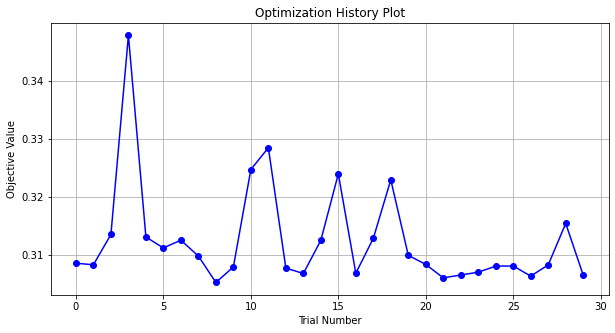

In [246]:
plt.figure(figsize=(10, 5))
plt.plot(iter_final['number'], iter_final['value'], marker='o', linestyle='-', color='b')
plt.title('Optimization History Plot')
plt.xlabel('Trial Number')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()
# Plot parameter importance
plot_param_importances(study)
plt.show()

In [220]:
model = LGBMRegressor(**study.best_params)
model.fit(X_train[a], y_train) 
y_pred = model.predict(X_test[a])#.astype(int)
test_mape = mape(y_test, y_pred)  
print("MAPE on test data: {:.2f}".format(test_mape))

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9432018562082192. Current value: feature_fraction=0.9432018562082192
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.5557905592778924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5557905592778924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
MAPE on test data: 31.00


In [221]:
y_pred_val=model.predict(X_val[a])
y_pred_train=model.predict(X_train[a])

In [222]:
y_pred_val = model.predict(X_val[a])
val_mape = mape(y_val, y_pred_val)  
print("MAPE on val data: {:.2f}".format(val_mape))

MAPE on test data: 30.67


In [223]:
out_train2=evaluar_predicciones(y_train,y_pred_train)
out_val2=evaluar_predicciones(y_val,y_pred_val)

In [224]:
classifications = out_train2['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_train2[out_train2['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_t = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_t.reset_index(inplace=True)
df_results_t.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_t)

     Classification    RMSE    MAPE     MAE
0  Dentro del rango 15.5142  9.5372 11.9190
1         Subestima 76.3356 33.5399 66.3175
2        Sobrestima 41.2642 52.1204 35.8990


In [225]:
classifications = out_val2['Clasificación'].unique()
results_by_classification = {}
for classification in classifications:
    segment = out_val2[out_val2['Clasificación'] == classification]
    y_pred_segment = segment['Predicción']
    y_segment = segment['Real']
    rmse, mape, mae = evaluate_regression_metrics(y_segment, y_pred_segment)
    
    # Guardar los resultados en el diccionario
    results_by_classification[classification] = {
        'RMSE': rmse,
        'MAPE': mape,
        'MAE': mae
    }
df_results_val = pd.DataFrame.from_dict(results_by_classification, orient='index')
df_results_val.reset_index(inplace=True)
df_results_val.rename(columns={'index': 'Classification'}, inplace=True)
print(df_results_val)

     Classification    RMSE    MAPE     MAE
0        Sobrestima 43.1303 54.5291 37.4810
1  Dentro del rango 15.7116  9.7184 12.1272
2         Subestima 78.8321 34.2651 68.4138


In [226]:
df_results_t['set']='train'
df_results_val['set']='test'

In [227]:
iter3=pd.concat([df_results_t,df_results_val]).sort_values('Classification')


In [228]:
iter_3_count=out_val2['Clasificación'].value_counts(1)*100

In [229]:
display(iter3)
iter_3_count

,Classification,RMSE,MAPE,MAE,set
0,Dentro del rango,15.5142,9.5372,11.9190,train
1,Dentro del rango,15.7116,9.7184,12.1272,test
2,Sobrestima,41.2642,52.1204,35.8990,train
0,Sobrestima,43.1303,54.5291,37.4810,test
1,Subestima,76.3356,33.5399,66.3175,train
2,Subestima,78.8321,34.2651,68.4138,test


Dentro del rango   44.7131
Sobrestima         36.4369
Subestima          18.8500
Name: Clasificación, dtype: float64

In [230]:
display(iter2)
iter_2_count

,Classification,RMSE,MAPE,MAE,set
1,Dentro del rango,15.4081,9.4631,11.7653,train
1,Dentro del rango,15.7902,9.7910,12.1981,test
2,Sobrestima,41.0149,51.5491,35.8054,train
0,Sobrestima,44.0490,55.1008,38.2134,test
0,Subestima,73.5766,32.9841,63.7256,train
2,Subestima,77.8808,34.2536,67.2031,test


Dentro del rango   44.9309
Sobrestima         35.9469
Subestima          19.1223
Name: Clasificación, dtype: float64

In [232]:
display(iter1_)
iter_1_count

,Classification,RMSE,MAPE,MAE,set
0,Dentro del rango,15.3511,9.0709,11.4414,train
1,Dentro del rango,15.3592,9.4865,11.7245,test
2,Sobrestima,35.2045,45.0998,30.7953,train
0,Sobrestima,44.3776,54.8938,38.3902,test
1,Subestima,66.7031,29.5994,59.4063,train
2,Subestima,77.5797,34.1978,67.1186,test


Dentro del rango   45.7476
Sobrestima         35.3588
Subestima          18.8936
Name: Clasificación, dtype: float64

In [234]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train[a])

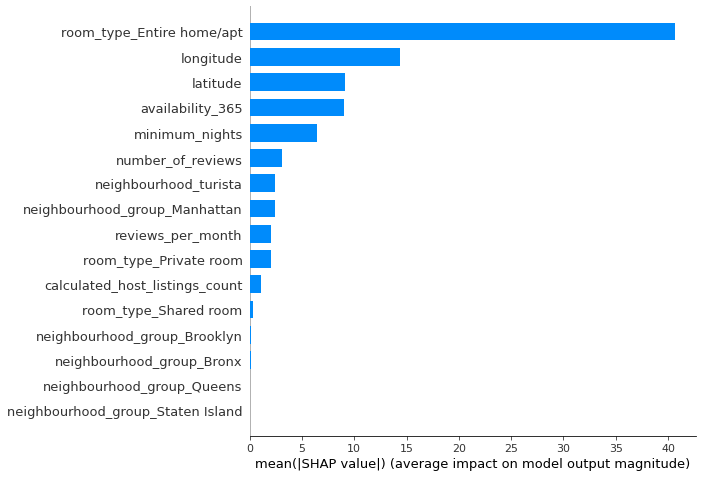

In [235]:
shap.summary_plot(shap_values, X_train[a], plot_type="bar")

* Tal como se menciona en la presentación de dicho mnotebook la ubicacón geografica y el numero de revisiones es un determinate del precio.
* La variable creada dicotomica si el barrio es turistico o no, fue importante y ayudó a no perder información


In [239]:
joblib.dump(model, 'objetos/best_model_iter_cv.joblib')

['objetos/best_model_iter_cv.joblib']

In [248]:

X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
X_val_df = pd.DataFrame(X_val)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_val_df = pd.DataFrame(y_val)

In [249]:
# Save to CSV
X_train_df.to_csv('objetos/datasets/X_train.csv', index=False)
X_test_df.to_csv('objetos/datasets/X_test.csv', index=False)
X_val_df.to_csv('objetos/datasets/X_val.csv', index=False)
y_train_df.to_csv('objetos/datasets/y_train.csv' )
y_test_df.to_csv('objetos/datasets/y_test.csv')
y_val_df.to_csv('objetos/datasets/y_val.csv')
